In [11]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Lambda
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_addons as tfa

import numpy as np
import math
import matplotlib.pyplot as plt
import time
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

from data.pamap2.pamap2 import create_pamap2
from other_models.attention import har_model
from other_models.attention.attentive_pooling import AttentionWithContext

In [12]:
secs = time.time()
tm = time.localtime(secs)

time_string = time.strftime('%Y%m%d%I%M%S', tm)
time_int = int(time_string) % (2**32 - 1)
time_string = str(time_int)
print('random_state : ' , time_int)

random_state :  4212007180


In [74]:
def CNN_Set(input_shape, kernel_size, name="Set"):
    
    inputs = tf.keras.layers.Input(input_shape)
    conv1 = tf.keras.layers.Conv1D(64, kernel_size=kernel_size, activation="relu")
    conv2 = tf.keras.layers.Conv1D(32, kernel_size=kernel_size, activation="relu")
    dropout = tf.keras.layers.Dropout(0.5)
    maxpooling = tf.keras.layers.MaxPool1D(pool_size=2)
    flatten = tf.keras.layers.Flatten()
    
    x = tf.keras.layers.TimeDistributed(conv1)(inputs)
    x = tf.keras.layers.TimeDistributed(conv2)(x)
    x = tf.keras.layers.TimeDistributed(dropout)(x)
    x = tf.keras.layers.TimeDistributed(maxpooling)(x)
    x = tf.keras.layers.TimeDistributed(flatten)(x)
    
    model = tf.keras.models.Model(inputs, x, name=name)
    return model

def Encoder(input_shape, name="encoder"):
    
    attention = har_model.create_model(100, 18, _dff=256, d_model=128, nh=4, dropout_rate=0.2, use_pe=False)

    inputs = tf.keras.layers.Input(input_shape)
    output = attention(inputs)
    
    model = tf.keras.models.Model(inputs, output, name=name)
    return model

def Balancing_Contrastive(input_shape, contrastive_outputs, n_outputs):
    inputs = tf.keras.layers.Input(input_shape)
    encoded = Encoder(input_shape)(inputs)
    
    ### classifier
    encoded_2 = tf.reshape(encoded, (-1, 4, 25, 128))
    encoded_2_shape = encoded_2.get_shape()
    branch_1 = CNN_Set(encoded_2_shape[1:], kernel_size=3, name="branch_1")
    branch_2 = CNN_Set(encoded_2_shape[1:], kernel_size=7, name="branch_2")
    branch_3 = CNN_Set(encoded_2_shape[1:], kernel_size=11, name="branch_3")      
    
    one = branch_1(encoded_2)
    two = branch_2(encoded_2)
    three = branch_3(encoded_2)
    concat = tf.keras.layers.Concatenate()([one, two, three])
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(concat)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False))(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    classified = tf.keras.layers.Dense(n_outputs, activation="softmax", name="classified")(x)
    
    ### contrastive
    x = AttentionWithContext()(encoded)
    contrastive = tf.keras.layers.LayerNormalization()(x)
#     contrastive = tf.keras.layers.Dense(contrastive_outputs, activation="relu", name="contrastive")(x)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=[classified, contrastive], name="Balancing")     
    return model

In [75]:
def plot_training_loss(H, plotPath):
        # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    if plotPath is not None:
        plt.savefig(plotPath)
    else:
        plt.show()

def plot_training_acc(H, plotPath):
        # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["classified_accuracy"], label="train_accuracy")
    plt.plot(H.history["val_classified_accuracy"], label="val_accuracy")
    plt.title("Training accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("accuracy")
    plt.legend(loc="lower left")
    if plotPath is not None:
        plt.savefig(plotPath)
    else:
        plt.show()

def print_test_result(model, filepath, x_test, y_classified, y_contrastive, dataset="wisdm"):
    model.load_weights(filepath)
    test_results = model.evaluate([x_test], [y_classified, y_contrastive])
    y_pred = model.predict([x_test])[0]
    matrix = confusion_matrix(y_classified, y_pred.argmax(axis=1))

    print("test acc  : ", test_results[3])
    print("test loss : ", test_results[0])

    score = f1_score(y_classified, y_pred.argmax(axis=1), average="macro")
    print("f1 score  : ", score)

    print(matrix)
    fontdict={'fontsize': 12}
    if dataset == "wisdm":
        label = ["Jogging", "LyingDown", "Sitting", "Stairs", "Stading", "Walking"]
    elif dataset == "pamap2":
        label = ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling', 'Nordic_walking', 'ascending_stairs', 'descending_stairs', 'vacuum_cleaning', 'ironing', 'rope_jumping']
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix, interpolation="nearest", cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(label)))
    ax.set_xticklabels(label)
    ax.set_yticks(np.arange(len(label)))
    ax.set_yticklabels(label)
    plt.xticks(rotation = 90)
    
    ax.set_xlabel("Predicted label", **fontdict)
    ax.set_ylabel("True label", **fontdict)
    
    plt.show()

In [76]:
def create_dataset(name, data_type="frequency_100"):
    print("creating dataset")
    if name == "pamap2":
        x_train, y_train = create_pamap2(data=data_type)
#         x_train = x_train.reshape(-1, 4, 25, 18)

        if data_type == "frequency_100":
            # # 80%, 10%, 10% respectively in train, val, test dataset
            x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=time_int, stratify=y_train)
            x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=time_int, stratify=y_test)
            print("x_train.shape : ", x_train.shape, "y_train.shape: ", y_train.shape)
            print("x_val.shape   : ", x_val.shape,    "y_val.shape: ", y_val.shape)
            print("x_test.shape  : ", x_test.shape,   "y_test.shape: ", y_test.shape)
            
            return x_train, y_train, x_val, y_val, x_test, y_test
        elif data_type == "frequency_20":
            # 80%, 10%, 10% respectively in train, val, test dataset
            x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=time_int, stratify=y_train)
            x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=time_int, stratify=y_test)
            print("x_train.shape : ", x_train.shape, "y_train.shape: ", y_train.shape)
            print("x_val.shape   : ", x_val.shape,    "y_val.shape: ", y_val.shape)
            print("x_test.shape  : ", x_test.shape,   "y_test.shape: ", y_test.shape)

        elif data_type == "nooverlap":

            # 80%, 10%, 10% respectively in train, val, test dataset
            x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=time_int, stratify=y_train)
            x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=time_int, stratify=y_test)
            print("x_train.shape : ", x_train.shape, "y_train.shape: ", y_train.shape)
            print("x_val.shape   : ", x_val.shape,    "y_val.shape: ", y_val.shape)
            print("x_test.shape  : ", x_test.shape,   "y_test.shape: ", y_test.shape)

            return x_train, y_train, x_val, y_val, x_test, y_test

In [77]:
batch = 16
epcohs = 100
learning_rate = 0.0001

In [78]:
class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)
    
class SampleContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, batch, lam=0.0001, beta=0.5, margin=1.2, name=None):
        super(SampleContrastiveLoss, self).__init__(name=name)
        self.batch = batch
        self.lam = lam
        self.beta = beta
        self.margin = margin
        
        self.tril = tf.cast(tf.linalg.band_part(tf.ones(shape=(batch, batch)), -1, 0) == 1, tf.bool)
        # self.tril = tf.cast(tf.linalg.band_part(tf.ones(shape=(batch, batch)), -1, 0) == 1, tf.int32)
        self.crossentropy = tf.keras.losses.SparseCategoricalCrossentropy()
        
    def __call__(self, labels, feature_vectors, sample_weight=None):
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        r1 = tf.matmul(feature_vectors_normalized, tf.transpose(feature_vectors_normalized))
        r2 = tf.abs(tf.subtract(tf.expand_dims(labels, axis=1), tf.expand_dims(labels, axis=0)))
        r2 = tf.experimental.numpy.squeeze(r2, axis=-1)
        
        mask1 = tf.where(self.tril, tf.ones(shape=(self.batch, self.batch)), tf.cast(r2, tf.float32)) == 0
        mask2 = tf.where(self.tril, tf.zeros(shape=(self.batch, self.batch)), tf.cast(r2, tf.float32)) > 0
        
        sample_loss = self.lam * tf.math.reduce_sum(r1[mask1]) + self.beta * tf.nn.relu(tf.math.reduce_sum(self.margin - r1[mask2]))
        sample_loss = sample_loss / batch
        return sample_loss

# Frequency 100Hz Testing

In [79]:
dataset_name = "pamap2"  
frequency_100_x_train, frequency_100_y_train, frequency_100_x_val, frequency_100_y_val, frequency_100_x_test, frequency_100_y_test = create_dataset(name=dataset_name, data_type="nooverlap")

## tensorflow에서 labels의 batch를 실시간으로 받을 수가 없고, 계속 None으로 계산됩니다.
## 이를 해결하기 위하여 pyotorch의 drop_last과 같이 batch가 항상 32개로 받도록 조정합니다.
frequency_100_x_train = frequency_100_x_train[frequency_100_x_train.shape[0]%batch:]
frequency_100_y_train = frequency_100_y_train[frequency_100_y_train.shape[0]%batch:]
frequency_100_x_val = frequency_100_x_val[frequency_100_x_val.shape[0]%batch:]
frequency_100_y_val = frequency_100_y_val[frequency_100_y_val.shape[0]%batch:]
frequency_100_x_test = frequency_100_x_test[frequency_100_x_test.shape[0]%batch:]
frequency_100_y_test = frequency_100_y_test[frequency_100_y_test.shape[0]%batch:]

# contrastive_y_train = np.argmax(frequency_100_y_train, axis=1)
# contrastive_y_val = np.argmax(frequency_100_y_val, axis=1)
# contrastive_y_test = np.argmax(frequency_100_y_test, axis=1)

print("contrastive_y_train shape : ", frequency_100_y_train.shape)
print("contrastive_y_val shape : ", frequency_100_y_val.shape)
print("contrastive_y_test shape : ", frequency_100_y_test.shape)

creating dataset
/home/tolom/20220621/contrastive_frequency
x_train.shape :  (15502, 100, 18) y_train.shape:  (15502,)
x_val.shape   :  (1938, 100, 18) y_val.shape:  (1938,)
x_test.shape  :  (1938, 100, 18) y_test.shape:  (1938,)
contrastive_y_train shape :  (15488,)
contrastive_y_val shape :  (1936,)
contrastive_y_test shape :  (1936,)


In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"

filepath = "result/frequency_" + dataset_name + "_" + time_string + ".h5"
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_classified_loss', factor=0.2, patience=5, min_lr=0.001)
checkpoint = ModelCheckpoint(filepath, verbose = 0, monitor="val_classified_loss", mode="min", save_best_only=True, save_weights_only = True)

print("[Prtraninig Encoder with Supervised Contrastive Loss]")
model = Balancing_Contrastive(frequency_100_x_train.shape[1:], 64, len(np.unique(frequency_100_y_train)))
model.summary()

model.compile(loss=["sparse_categorical_crossentropy", SampleContrastiveLoss(batch)], loss_weights=[0.5, 0.5], optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])
# history = model.fit(frequency_100_x_train, [frequency_100_y_train, contrastive_y_train], validation_data=(frequency_100_x_val, [frequency_100_y_val, contrastive_y_val]), batch_size=32, epochs=50, verbose=1, callbacks=[reduce_lr, checkpoint])
history = model.fit(frequency_100_x_train, [frequency_100_y_train, frequency_100_y_train], validation_data=(frequency_100_x_val, [frequency_100_y_val, frequency_100_y_val]), batch_size=batch, epochs=epcohs, verbose=1, callbacks=[reduce_lr, checkpoint])
print("[Finished Prtraining]")

[Prtraninig Encoder with Supervised Contrastive Loss]
Model: "Balancing"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 100, 18)]    0           []                               
                                                                                                  
 encoder (Functional)           (None, 100, 128)     268581      ['input_35[0][0]']               
                                                                                                  
 tf.reshape_4 (TFOpLambda)      (None, 4, 25, 128)   0           ['encoder[0][0]']                
                                                                                                  
 branch_1 (Functional)          (None, 4, 320)       30816       ['tf.reshape_4[0][0]']           
                                    

2022-06-23 18:56:14.423394: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-06-23 18:56:17.625761: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


968/968 [==============================] - 49s 33ms/step - loss: 0.9126 - classified_loss: 0.9984 - layer_normalization_36_loss: 0.8268 - classified_accuracy: 0.7016 - layer_normalization_36_accuracy: 0.0000e+00 - val_loss: 0.7301 - val_classified_loss: 0.6803 - val_layer_normalization_36_loss: 0.7799 - val_classified_accuracy: 0.8032 - val_layer_normalization_36_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
968/968 [==============================] - 29s 30ms/step - loss: 0.6489 - classified_loss: 0.5503 - layer_normalization_36_loss: 0.7475 - classified_accuracy: 0.8537 - layer_normalization_36_accuracy: 0.0000e+00 - val_loss: 0.6402 - val_classified_loss: 0.5300 - val_layer_normalization_36_loss: 0.7503 - val_classified_accuracy: 0.8631 - val_layer_normalization_36_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/100
968/968 [==============================] - 30s 31ms/step - loss: 0.5894 - classified_loss: 0.4525 - layer_normalization_36_loss: 0.7263 - classified_accuracy: 0.8773 - 

Random State :  4211994467


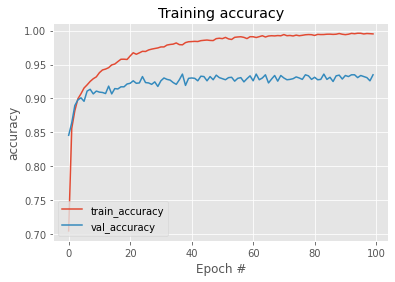

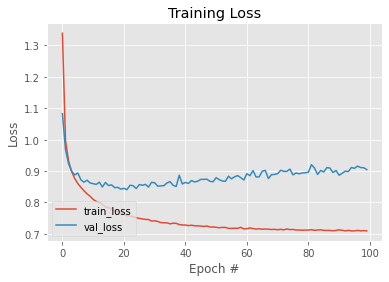

60/60 [==============================] - 3s 11ms/step - loss: 0.8403 - classified_loss: 0.2742 - contrastive_loss: 1.4065 - classified_accuracy: 0.9177 - contrastive_accuracy: 0.0000e+00
test acc  :  0.9177083373069763
test loss :  0.8403373956680298
f1 score  :  0.912781009846093
[[187   1   1   0   0   0   0   0   0   1   0   0]
 [  2 173   5   0   0   0   0   1   0   1   3   0]
 [  3   1 178   0   0   0   0   1   1   0   5   0]
 [  1   0   3 221   0   0   1   4   4   0   1   0]
 [  0   1   1   2  91   0   0   1   0   0   1   0]
 [  0   0   0   0   0 154   0   0   0   1   6   0]
 [  0   0   1   2   0   1 178   3   0   1   1   0]
 [  3   0   9   3   1   0   1  92   5   1   1   0]
 [  1   0   5   1   0   1   0   6  80   7   2   0]
 [  0   0   4   0   0   1   0   3   0 147  16   0]
 [  0   0   7   0   1   0   0   4   1   5 220   0]
 [  1   0   0   0   0   0   0   1   0   0   5  41]]


/tmp/ipykernel_670099/2615747285.py:52: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cax)


<Figure size 432x288 with 0 Axes>

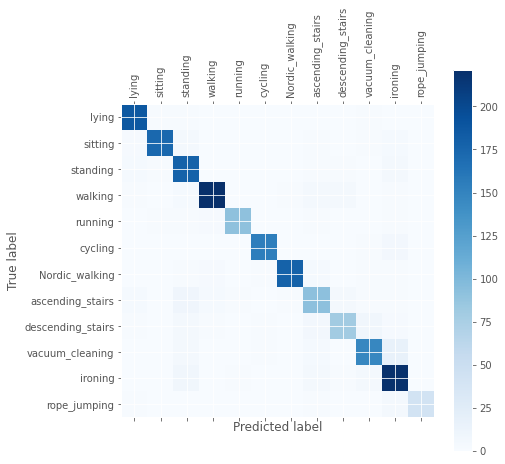

In [11]:
print("Random State : ", time_string)
plot_training_acc(history, None)
plot_training_loss(history, None)
plt.clf()
print_test_result(model, filepath, frequency_100_x_test, frequency_100_y_test, frequency_100_y_test, dataset=dataset_name)